# GOOG Stock Price Prediction — Multi-feature LSTM/BiLSTM/GRU
**What we'll do in this notebook (overview)**  
1. Load GOOG historical data (Yahoo Finance)  
2. Exploratory Data Analysis (EDA) — understand the data and distributions  
3. Preprocessing — select features, handle missing values, scale features  
4. Create sequences (multivariate) for LSTM models (X = sequences of features, y = next-day Close)  
5. Train/validation/test split (time-series safe split)  
6. Build and train three models: LSTM, BiLSTM, GRU  
7. Evaluate models (RMSE, MAE, R²) and visualize predictions  
8. Forecast next 30 days (using last available window)  
9. Save models & scaler for deployment  


In [1]:
# Cell 2 — Imports & seeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import os
import math
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Why multiple features?
Using `Open, High, Low, Close, Volume` gives the model more context about intraday range and market activity.  
**Benefit:** More informative input → model can learn richer patterns than using `Close` only.


In [2]:
# Cell 2 — Configuration & Hyperparameters
TICKER = "GOOG"
START = "2015-01-01"
END = datetime.date.today().strftime("%Y-%m-%d")
SEQ_LEN = 60         # how many past days we feed to predict next day
FUTURE_DAYS = 30     # forecast horizon for final demo
TEST_RATIO = 0.15
VAL_RATIO = 0.10
BATCH = 32
EPOCHS = 30
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Config:", TICKER, START, END)


Config: GOOG 2015-01-01 2025-10-14


## Step 1 — Download data
We use `yfinance` to fetch historical OHLCV (Open, High, Low, Close, Volume).

In [3]:
# Cell 3 — Download data
df = yf.download(TICKER, start=START, end=END)
df.head()


/tmp/ipython-input-1167931927.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2015-01-02,25.990789,26.310717,25.955628,26.198791,28951268
2015-01-05,25.448999,25.967023,25.408886,25.914031,41196796
2015-01-06,24.859165,25.563153,24.814100,25.504961,57998800
2015-01-07,24.816576,25.120852,24.744766,25.108768,41301082
2015-01-08,24.894821,24.934440,24.316378,24.662553,67071641


## Quick EDA — understand shape and missing values
We check basic stats, visualize Close price, and view correlations.

In [4]:
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
display(df.describe().T)

Shape: (2711, 5)

Missing values per column:
 Price   Ticker
Close   GOOG      0
High    GOOG      0
Low     GOOG      0
Open    GOOG      0
Volume  GOOG      0
dtype: int64


,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
Close,GOOG,2711.0,8.991992e+01,5.134172e+01,2.439314e+01,4.763800e+01,7.147240e+01,1.322152e+02,2.552400e+02
High,GOOG,2711.0,9.084674e+01,5.190234e+01,2.456281e+01,4.802237e+01,7.210606e+01,1.331786e+02,2.567000e+02
Low,GOOG,2711.0,8.894826e+01,5.074898e+01,2.414601e+01,4.723427e+01,7.083029e+01,1.303463e+02,2.520680e+02
Open,GOOG,2711.0,8.985805e+01,5.129529e+01,2.449714e+01,4.757990e+01,7.163379e+01,1.320066e+02,2.547800e+02
Volume,GOOG,2711.0,3.025954e+07,1.517127e+07,6.809800e+06,2.088280e+07,2.656600e+07,3.502600e+07,2.232980e+08


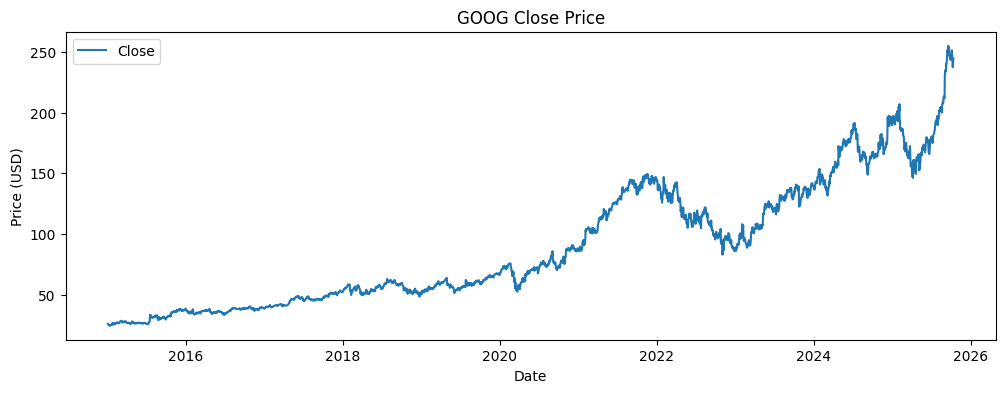

In [5]:
plt.figure(figsize=(12,4))
plt.plot(df['Close'], label='Close')
plt.title(f"{TICKER} Close Price")
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## Why check correlations?
To see whether Volume or other features have relationships with Close — helpful for feature selection.


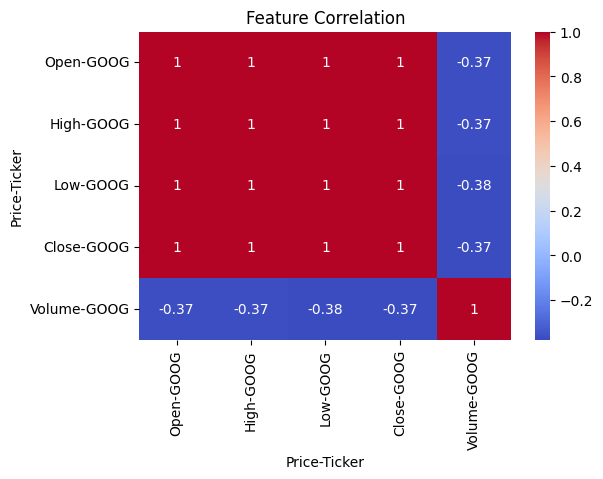

In [6]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()  # shape (n_samples, 1)


In [7]:
df['open_close'] = df['Open'] - df['Close']
df['low_high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'],1,0)

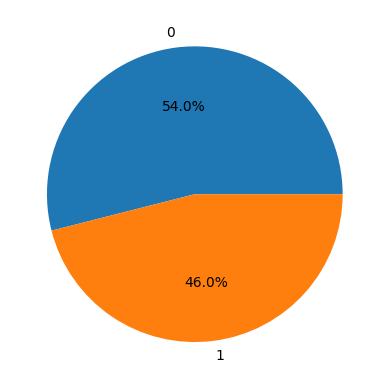

In [8]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

In [9]:
df.reset_index(inplace = True)

In [10]:
df.Date = pd.to_datetime(df['Date'])

In [11]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

/tmp/ipython-input-2213799094.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  sb.heatmap(df.drop('Date', axis=1).corr() > 0.9, annot=True, cbar=False)


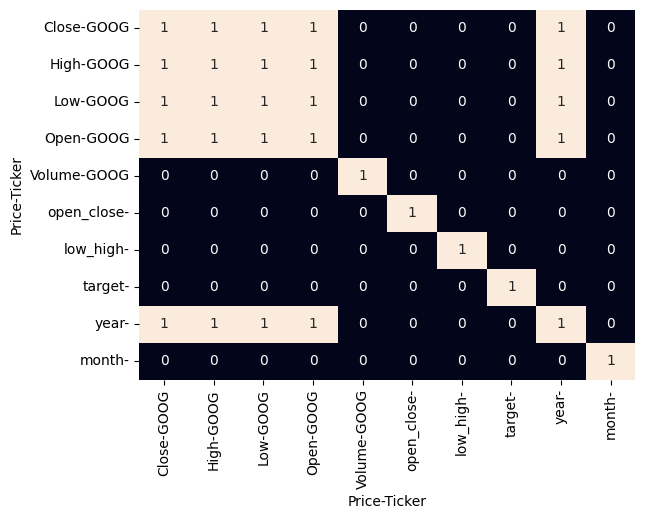

In [12]:
import seaborn as sb
sb.heatmap(df.drop('Date', axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

In [13]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

Price,Date,Close,High,Low,Open,Volume,open_close,low_high,target,year,month,is_quarter_end
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG,,,,,,
0,2015-01-02,25.990789,26.310717,25.955628,26.198791,28951268,0.208002,-0.355089,0,2015,1,0
1,2015-01-05,25.448999,25.967023,25.408886,25.914031,41196796,0.465032,-0.558137,0,2015,1,0
2,2015-01-06,24.859165,25.563153,24.814100,25.504961,57998800,0.645796,-0.749053,0,2015,1,0
3,2015-01-07,24.816576,25.120852,24.744766,25.108768,41301082,0.292192,-0.376087,1,2015,1,0
4,2015-01-08,24.894821,24.934440,24.316378,24.662553,67071641,-0.232269,-0.618062,0,2015,1,0


In [14]:
df.drop('Date', axis=1).groupby('is_quarter_end').mean()

/tmp/ipython-input-1194725523.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop('Date', axis=1).groupby('is_quarter_end').mean()


Price,Close,High,Low,Open,Volume,open_close,low_high,target,year,month
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,,,,,
is_quarter_end,,,,,,,,,,
0,89.704809,90.623358,88.729127,89.621227,3.013284e+07,-0.083581,-1.894231,0.552106,2019.914634,6.013858
1,90.347760,91.291032,89.384099,90.329097,3.051155e+07,-0.018663,-1.906933,0.514884,2019.852260,7.329658


# First WE Train model for Next Day Price Prediction(regression) and then train model for trend(classification)

## Step 2 — Preprocessing
**Decisions and why:**  
- Keep features: `Open, High, Low, Close, Volume` (multivariate).  
- Fill missing values (if any) with forward-fill — keeps chronological consistency.  
- Scale features using `MinMaxScaler` (0–1) — LSTMs perform better with scaled inputs.


In [15]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features].copy()
data = data.ffill().dropna()   # forward fill then drop remaining NaNs if any
print("After ffill shape:", data.shape)

After ffill shape: (2711, 5)


In [16]:
import joblib
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)   # shape (n_days, 5)
# Save scaler to reuse in deployment
joblib.dump(scaler, os.path.join(MODEL_DIR, "multiple_input_scaler.gz"))
print("Scaler saved.")

Scaler saved.


## Step 3 — Sequence creation (multivariate)
We convert series to supervised sequences:
- X: past `SEQ_LEN` days × `n_features`
- y: next day `Close` (note: we use the **Close** value as target)
**Why:** LSTM/GRU expect 3D input: (samples, timesteps, features).


In [17]:
# Cell 8 — create sequences (multivariate)
def create_multivariate_sequences(scaled_array, seq_len):
    X, y = [], []
    for i in range(seq_len, len(scaled_array)):
        X.append(scaled_array[i-seq_len:i, :])   # seq_len x n_features
        # target: next-day close (column index for 'Close' is 3 in our features)
        y.append(scaled_array[i, features.index('Close')])
    X = np.array(X)
    y = np.array(y)
    return X, y

X_all, y_all = create_multivariate_sequences(scaled_data, SEQ_LEN)
print("X_all shape:", X_all.shape, "y_all shape:", y_all.shape)


X_all shape: (2651, 60, 5) y_all shape: (2651,)


In [18]:
y_all


array([0.01189585, 0.01072878, 0.00922061, ..., 0.94355566, 0.9231092 ,
       0.95408209])

## Step 4 — Train / Val / Test split (time-wise)
**Important:** For time series we **do not shuffle**. We split by index so future data is not used for training.


In [19]:
# Cell 9 — time-aware split
n = len(X_all)
test_size = int(n * TEST_RATIO)
val_size = int(n * VAL_RATIO)

train_end = n - test_size - val_size
val_end = n - test_size

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (1989, 60, 5) (1989,)
Val:   (265, 60, 5) (265,)
Test:  (397, 60, 5) (397,)


In [20]:
# Cell 10 — Helper build functions (simple & clear models)
def build_lstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_bilstm(input_shape, units=64, dropout=0.2):
    m = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape),
        Dropout(dropout),
        Bidirectional(LSTM(units//2)),
        Dropout(dropout),
        Dense(1)
    ])
    return m

def build_gru(input_shape, units=64, dropout=0.2):
    m = Sequential([
        GRU(units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        GRU(units//2),
        Dropout(dropout),
        Dense(1)
    ])
    return m


## Step 5 — Compile & Train helper
We use `EarlyStopping`, `ReduceLROnPlateau`, and `ModelCheckpoint`.  
**Why:** prevents overfitting and saves best model.


In [21]:
# Cell 11 — training helper
def compile_and_train(model, name, X_train, y_train, X_val, y_val, epochs=EPOCHS):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        ModelCheckpoint(os.path.join(MODEL_DIR, f"{name}.h5"), monitor='val_loss', save_best_only=True, verbose=1)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=BATCH, callbacks=callbacks, verbose=2)
    return history


In [22]:
# Cell 12 — Build & train LSTM (simple)
input_shape = (X_train.shape[1], X_train.shape[2])
lstm = build_lstm(input_shape, units=128, dropout=0.2)
lstm_hist = compile_and_train(lstm, "lstm_multifeature", X_train, y_train, X_val, y_val)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00108, saving model to saved_models/lstm_multifeature.h5


63/63 - 20s - 325ms/step - loss: 0.0089 - mae: 0.0560 - val_loss: 0.0011 - val_mae: 0.0280 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss improved from 0.00108 to 0.00056, saving model to saved_models/lstm_multifeature.h5


63/63 - 8s - 127ms/step - loss: 8.5139e-04 - mae: 0.0201 - val_loss: 5.6262e-04 - val_mae: 0.0182 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss did not improve from 0.00056
63/63 - 6s - 101ms/step - loss: 8.6005e-04 - mae: 0.0192 - val_loss: 6.3702e-04 - val_mae: 0.0204 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.00056 to 0.00053, saving model to saved_models/lstm_multifeature.h5


63/63 - 10s - 163ms/step - loss: 7.5302e-04 - mae: 0.0185 - val_loss: 5.3369e-04 - val_mae: 0.0183 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 5: val_loss improved from 0.00053 to 0.00050, saving model to saved_models/lstm_multifeature.h5


63/63 - 8s - 127ms/step - loss: 6.8365e-04 - mae: 0.0177 - val_loss: 4.9810e-04 - val_mae: 0.0172 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss did not improve from 0.00050
63/63 - 9s - 139ms/step - loss: 6.8830e-04 - mae: 0.0176 - val_loss: 5.3052e-04 - val_mae: 0.0183 - learning_rate: 5.0000e-05
Epoch 7/30

Epoch 7: val_loss did not improve from 0.00050
63/63 - 8s - 127ms/step - loss: 7.3082e-04 - mae: 0.0181 - val_loss: 5.4588e-04 - val_mae: 0.0186 - learning_rate: 5.0000e-05
Epoch 8/30

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 8: val_loss improved from 0.00050 to 0.00047, saving model to saved_models/lstm_multifeature.h5


63/63 - 10s - 162ms/step - loss: 6.4376e-04 - mae: 0.0172 - val_loss: 4.7242e-04 - val_mae: 0.0170 - learning_rate: 5.0000e-05
Epoch 9/30

Epoch 9: val_loss did not improve from 0.00047
63/63 - 7s - 104ms/step - loss: 6.1913e-04 - mae: 0.0165 - val_loss: 5.1770e-04 - val_mae: 0.0180 - learning_rate: 2.5000e-05
Epoch 10/30

Epoch 10: val_loss did not improve from 0.00047
63/63 - 8s - 126ms/step - loss: 6.4886e-04 - mae: 0.0170 - val_loss: 4.7657e-04 - val_mae: 0.0171 - learning_rate: 2.5000e-05
Epoch 11/30

Epoch 11: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 11: val_loss did not improve from 0.00047
63/63 - 11s - 168ms/step - loss: 6.8296e-04 - mae: 0.0175 - val_loss: 4.7527e-04 - val_mae: 0.0171 - learning_rate: 2.5000e-05
Epoch 12/30

Epoch 12: val_loss did not improve from 0.00047
63/63 - 8s - 133ms/step - loss: 6.3113e-04 - mae: 0.0169 - val_loss: 5.1016e-04 - val_mae: 0.0179 - learning_rate: 1.2500e-05
Epoch 13/30

Epoch 13: val_loss did not improve 

In [23]:
# Cell 13 — Build & train BiLSTM
bilstm = build_bilstm(input_shape, units=128, dropout=0.2)
bilstm_hist = compile_and_train(bilstm, "bilstm_multifeature", X_train, y_train, X_val, y_val)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.00092, saving model to saved_models/bilstm_multifeature.h5


63/63 - 23s - 368ms/step - loss: 0.0037 - mae: 0.0372 - val_loss: 9.2475e-04 - val_mae: 0.0242 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss did not improve from 0.00092
63/63 - 17s - 275ms/step - loss: 0.0010 - mae: 0.0217 - val_loss: 9.8218e-04 - val_mae: 0.0257 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss did not improve from 0.00092
63/63 - 17s - 271ms/step - loss: 8.1141e-04 - mae: 0.0192 - val_loss: 9.7841e-04 - val_mae: 0.0259 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: val_loss improved from 0.00092 to 0.00082, saving model to saved_models/bilstm_multifeature.h5


63/63 - 21s - 333ms/step - loss: 6.8542e-04 - mae: 0.0177 - val_loss: 8.2462e-04 - val_mae: 0.0234 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss improved from 0.00082 to 0.00058, saving model to saved_models/bilstm_multifeature.h5


63/63 - 16s - 259ms/step - loss: 6.3418e-04 - mae: 0.0169 - val_loss: 5.7566e-04 - val_mae: 0.0188 - learning_rate: 1.0000e-04
Epoch 6/30

Epoch 6: val_loss improved from 0.00058 to 0.00046, saving model to saved_models/bilstm_multifeature.h5


63/63 - 20s - 323ms/step - loss: 6.6510e-04 - mae: 0.0172 - val_loss: 4.5557e-04 - val_mae: 0.0162 - learning_rate: 1.0000e-04
Epoch 7/30

Epoch 7: val_loss improved from 0.00046 to 0.00041, saving model to saved_models/bilstm_multifeature.h5


63/63 - 18s - 283ms/step - loss: 5.5739e-04 - mae: 0.0157 - val_loss: 4.0912e-04 - val_mae: 0.0151 - learning_rate: 1.0000e-04
Epoch 8/30

Epoch 8: val_loss did not improve from 0.00041
63/63 - 16s - 257ms/step - loss: 5.0906e-04 - mae: 0.0155 - val_loss: 4.2649e-04 - val_mae: 0.0158 - learning_rate: 1.0000e-04
Epoch 9/30

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 9: val_loss improved from 0.00041 to 0.00038, saving model to saved_models/bilstm_multifeature.h5


63/63 - 16s - 256ms/step - loss: 4.8382e-04 - mae: 0.0148 - val_loss: 3.8320e-04 - val_mae: 0.0146 - learning_rate: 1.0000e-04
Epoch 10/30

Epoch 10: val_loss did not improve from 0.00038
63/63 - 16s - 258ms/step - loss: 4.7374e-04 - mae: 0.0146 - val_loss: 4.2701e-04 - val_mae: 0.0160 - learning_rate: 5.0000e-05
Epoch 11/30

Epoch 11: val_loss did not improve from 0.00038
63/63 - 18s - 281ms/step - loss: 4.5891e-04 - mae: 0.0147 - val_loss: 3.8694e-04 - val_mae: 0.0150 - learning_rate: 5.0000e-05
Epoch 12/30

Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 12: val_loss did not improve from 0.00038
63/63 - 16s - 257ms/step - loss: 4.9422e-04 - mae: 0.0149 - val_loss: 5.0646e-04 - val_mae: 0.0179 - learning_rate: 5.0000e-05
Epoch 13/30

Epoch 13: val_loss did not improve from 0.00038
63/63 - 21s - 335ms/step - loss: 4.4626e-04 - mae: 0.0143 - val_loss: 4.6325e-04 - val_mae: 0.0170 - learning_rate: 2.5000e-05
Epoch 14/30

Epoch 14: val_loss did not imp

In [24]:
# Cell 14 — Build & train GRU
gru = build_gru(input_shape, units=128, dropout=0.2)
gru_hist = compile_and_train(gru, "gru_multifeature", X_train, y_train, X_val, y_val)


Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00028, saving model to saved_models/gru_multifeature.h5


63/63 - 12s - 194ms/step - loss: 0.0055 - mae: 0.0496 - val_loss: 2.8445e-04 - val_mae: 0.0136 - learning_rate: 1.0000e-04
Epoch 2/30

Epoch 2: val_loss did not improve from 0.00028
63/63 - 6s - 102ms/step - loss: 0.0015 - mae: 0.0257 - val_loss: 4.6967e-04 - val_mae: 0.0181 - learning_rate: 1.0000e-04
Epoch 3/30

Epoch 3: val_loss improved from 0.00028 to 0.00023, saving model to saved_models/gru_multifeature.h5


63/63 - 8s - 125ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 2.3236e-04 - val_mae: 0.0118 - learning_rate: 1.0000e-04
Epoch 4/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_loss did not improve from 0.00023
63/63 - 7s - 116ms/step - loss: 9.3152e-04 - mae: 0.0202 - val_loss: 2.7279e-04 - val_mae: 0.0130 - learning_rate: 1.0000e-04
Epoch 5/30

Epoch 5: val_loss did not improve from 0.00023
63/63 - 7s - 112ms/step - loss: 8.5653e-04 - mae: 0.0191 - val_loss: 2.3698e-04 - val_mae: 0.0119 - learning_rate: 5.0000e-05
Epoch 6/30

Epoch 6: val_loss did not improve from 0.00023
63/63 - 8s - 125ms/step - loss: 8.4917e-04 - mae: 0.0194 - val_loss: 3.5869e-04 - val_mae: 0.0155 - learning_rate: 5.0000e-05
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 7: val_loss did not improve from 0.00023
63/63 - 9s - 140ms/step - loss: 7.8595e-04 - mae: 0.0189 - val_loss: 2.3350e-04 - val_mae: 0.0118 - learning_r

## Evaluation: metrics on test set
We compute RMSE, MAE, and R² on the **original price scale** (inverse transform).


In [25]:
# Cell 16 — evaluation helper (inverse transform predictions)
def invert_and_metrics(model, X, y_scaled, scaler, feature_index=features.index('Close')):
    preds_scaled = model.predict(X)
    # preds_scaled shape (n,1)
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))  # create placeholder
    preds_full[:, feature_index] = preds_scaled[:,0]
    preds_inv = scaler.inverse_transform(preds_full)[:, feature_index]

    y_full = np.zeros((len(y_scaled), scaled_data.shape[1]))
    y_full[:, feature_index] = y_scaled
    y_inv = scaler.inverse_transform(y_full)[:, feature_index]

    rmse = math.sqrt(mean_squared_error(y_inv, preds_inv))
    mae = mean_absolute_error(y_inv, preds_inv)
    r2 = r2_score(y_inv, preds_inv)
    return preds_inv, y_inv, rmse, mae, r2

# Evaluate LSTM
lstm_pred, y_test_inv, lstm_rmse, lstm_mae, lstm_r2 = invert_and_metrics(lstm, X_test, y_test, scaler)
print("LSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(lstm_rmse, lstm_mae, lstm_r2))

# Evaluate BiLSTM
bilstm_pred, _, bilstm_rmse, bilstm_mae, bilstm_r2 = invert_and_metrics(bilstm, X_test, y_test, scaler)
print("BiLSTM -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(bilstm_rmse, bilstm_mae, bilstm_r2))

# Evaluate GRU
gru_pred, _, gru_rmse, gru_mae, gru_r2 = invert_and_metrics(gru, X_test, y_test, scaler)
print("GRU -> RMSE: {:.3f}, MAE: {:.3f}, R2: {:.3f}".format(gru_rmse, gru_mae, gru_r2))


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
LSTM -> RMSE: 9.990, MAE: 7.731, R2: 0.817
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
BiLSTM -> RMSE: 9.113, MAE: 7.096, R2: 0.848
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU -> RMSE: 5.700, MAE: 4.329, R2: 0.941


## Visualize predictions vs actual (test set)
Plot results to visually check how well models track real prices.


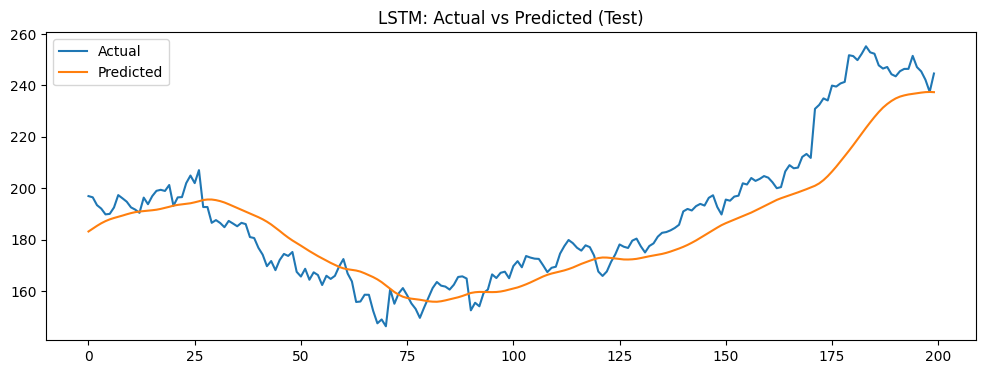

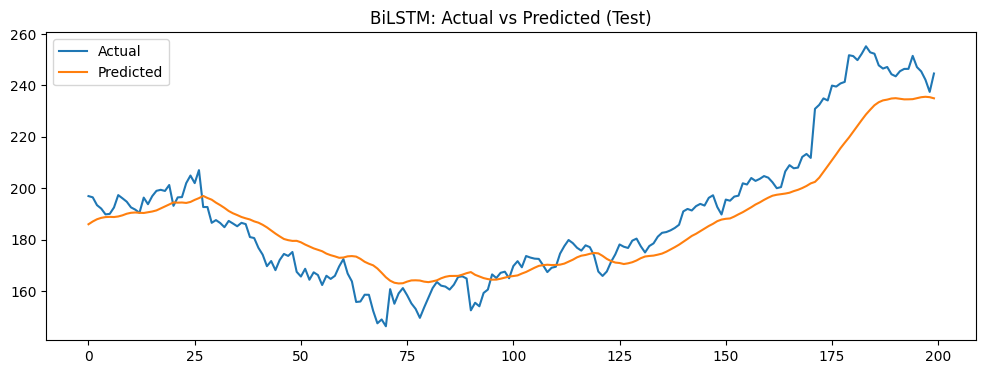

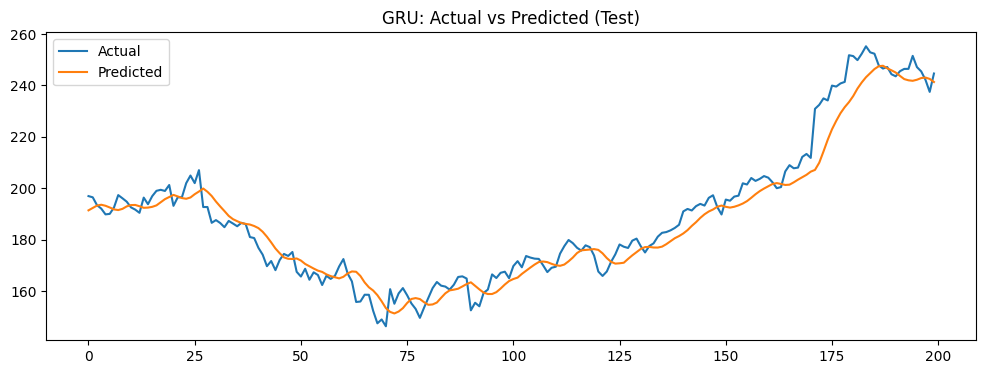

In [26]:
# Cell 17 — plot helper (last N points)
def plot_compare(y_true, preds, title, last_n=200):
    plt.figure(figsize=(12,4))
    plt.plot(y_true[-last_n:], label='Actual')
    plt.plot(preds[-last_n:], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_compare(y_test_inv, lstm_pred, "LSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, bilstm_pred, "BiLSTM: Actual vs Predicted (Test)", last_n=200)
plot_compare(y_test_inv, gru_pred, "GRU: Actual vs Predicted (Test)", last_n=200)


## Choose best model for forecasting
We choose GRU:
Why because rmse of gru is lower than other models which is only 6.176

In [27]:
# Cell 18 — pick best by RMSE
rmse_dict = {'lstm': lstm_rmse, 'bilstm': bilstm_rmse, 'gru': gru_rmse}
best_name = min(rmse_dict, key=rmse_dict.get)
print("Best model by RMSE:", best_name, rmse_dict)
best_model = {'lstm': lstm, 'bilstm': bilstm, 'gru': gru}[best_name]


Best model by RMSE: gru {'lstm': 9.990477800103728, 'bilstm': 9.112584394343472, 'gru': 5.69995897188099}


## Save best model for UI deployment
We already saved checkpoints during training; save best final copy and scaler (done earlier). This allows a Streamlit to load model + scaler and return predictions.


In [30]:
# Cell 20 — save best model name explicitly
best_model.save(os.path.join(MODEL_DIR, f"best_model_{best_name}.h5"))
print("Saved best model:", os.path.join(MODEL_DIR, f"best_model_{best_name}.h5"))


Saved best model: saved_models/best_model_gru.h5
